In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# %pip install -q ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

### Read data

In [2]:
basic_table = pd.read_csv("Model_2_data/mimic_cml_basic.csv")

lab_table = pd.DataFrame()
for i in range (1,7):
    each_lab_table = pd.read_csv("Model_2_data/mimic_cml_lab_%s.csv" %i)
    lab_table = pd.concat([lab_table,each_lab_table], ignore_index = True)
    
tki_table = pd.read_csv("Model_2_data/mimic_cml_tki.csv")

# This table gives all the medication patients took
drug_table = pd.read_csv("Model_2_data/mimic_cml_drug.csv")

diag_table = pd.read_csv("Model_2_data/mimic_cml_diagnoses.csv")

CVD_cml_patient =  pd.read_csv("Model_2_data/mimic_cml_cvd.csv")

In [3]:
### basic_table
data_patient = basic_table.drop('icd_code',axis=1).drop_duplicates()

data_patient['BMI'] = np.where(data_patient['result_name'] == 'BMI (kg/m2)', data_patient['result_value'] , np.nan)

def systolic(bp):
    return int(bp.split('/')[0])
def diastolic(bp):
    return int(bp.split('/')[1])

mask = data_patient['result_name'] == 'Blood Pressure'
data_patient['diastolic'] = data_patient.loc[mask, 'result_value'].apply(diastolic)
data_patient['systolic'] = data_patient.loc[mask, 'result_value'].apply(systolic)
# data_patient

In [4]:
data_patient['BMI'] = pd.to_numeric(data_patient['BMI'])
                                    
data_patient_bmi = data_patient.groupby('subject_id')['BMI'].mean().reset_index()

In [5]:
data_patient

,subject_id,gender,anchor_age,result_name,result_value,BMI,diastolic,systolic
0,10942537,M,64,Blood Pressure Lying,136/65,NaN,NaN,NaN
2,10942537,M,64,Blood Pressure Sitting,142/71,NaN,NaN,NaN
4,10942537,M,64,Blood Pressure Standing (1 min),114/62,NaN,NaN,NaN
6,10913302,M,25,BMI (kg/m2),26.6,26.6,NaN,NaN
9,12868814,F,57,BMI (kg/m2),23.2,23.2,NaN,NaN
...,...,...,...,...,...,...,...,...
101960,17833222,M,35,Height (Inches),70.2,NaN,NaN,NaN
101963,17960448,M,68,Height (Inches),70.88,NaN,NaN,NaN
101964,17960448,M,68,Height (Inches),70.9,NaN,NaN,NaN
101965,18323186,M,51,Height (Inches),69.1,NaN,NaN,NaN


In [6]:
data_patient_bp = pd.merge(data_patient[['subject_id','diastolic']].drop_duplicates().groupby('subject_id')['diastolic'].mean().reset_index(),
                     data_patient[['subject_id','systolic']].drop_duplicates().groupby('subject_id')['systolic'].mean().reset_index(),
                     on='subject_id',how='left')
data_patient_bmi_bp = pd.merge(data_patient_bmi, data_patient_bp, on='subject_id',how='left')

data_patient_cleaned = pd.merge(data_patient[['subject_id','gender','anchor_age']].drop_duplicates(), data_patient_bmi_bp, on='subject_id',how='left')
data_patient_cleaned['gender'] = np.where(data_patient_cleaned.gender == 'M', 1, 0)


In [7]:
# data_patient_cleaned

In [8]:
def add_cvd_variable(ICD_9_CVD,diag_table):
    numbers_string = tuple(str(num) for num in ICD_9_CVD)
    
    diag_cvd = diag_table[diag_table['icd_code'].str.startswith(numbers_string)]
    
    patient_cvd = pd.DataFrame(diag_cvd.subject_id.drop_duplicates())
    
    return patient_cvd

410-414 ischaemic heart disease |

415-417 diseases of pulmonary circulation

4420-429 other forms of heart disease

430-438 cerebrovascular disease -> relevant as it would include cerebrovascular accident

440-449 Diseases of arterioles, arteries and capillaries -> needs to be included as it includes dissection of aorta and ruptured aneurysms which are also life threatening

In [9]:
### Most of patients have one CVD ICD9 from 390-459
### based on Lyon CVD CML paper: we selected Arterial thrombosis, (434, 444)
### (myocardial infarction, stroke and PAODa ) 
### Venous thromboembolism
### Hypertension
### Heart failure and asymptomatic LVSD Atherosclerosisb
### QTc prolongationb
### Pulmonary hypertensionc

### Hypertensive disease (401–405)
###Ischemic heart disease (410–414)
### Diseases of pulmonary circulation (415–417)

# all:
# ICD_9_CVD = [401,402,403,404,405,434,444,410,411,412,413,414,415,416,417,428,429,440] # CVD related disease ICD code 390, 459

# 'hypertensive','ischemic','pulmonary','other','all'

ICD_9_dict = {'hypertensive': range(401,406,1),
            'ischemic': range(410,415,1), # 415
            'pulmonary': range(415,418,1), #418
              'other': range(420,430,1),
              'cerebrovascular':range(430,439,1),
              'arterioles':range(440,450,1),
             'all': list(range(401,405,1))+list(range(410,418,1))+list(range(420,450,1)),
             'diabetes': range(250,251,1),
             'CML': range(2051,2052,1)}
for key in ICD_9_dict.keys():
    CVD_type = key
    ICD_9_CVD = ICD_9_dict[CVD_type]
    patient_cvd = add_cvd_variable(ICD_9_CVD,diag_table)

    data_patient_cleaned[CVD_type] = np.where(data_patient_cleaned.subject_id.isin(patient_cvd.subject_id), 1, 0)
    

In [10]:
### Only include patient with 205.1 (CML)
# data_patient_cleaned = data_patient_cleaned[data_patient_cleaned['CML']==1]
# data_patient_cleaned = data_patient_cleaned.drop('CML', axis=1)
# data_patient_cleaned

In [11]:
# numbers_string = tuple(str(num) for num in ICD_9_CVD)

# diag_cvd = diag_table[diag_table['icd_code'].str.startswith(numbers_string)]

# diag_cvd.icd_code.value_counts().sort_index().to_csv("cvd_icd9.csv")

# diag_table[diag_table['icd_code'].str.startswith('2051')]

In [12]:
### Standardize medication name

In [13]:
import pandas as pd

# mapping dictionary
# IMATINIB, DASATINIB, NILOTINIB, BOSUTINIB ICLUSIG JAKAVI
drug_mapping = {
    'imatinib': 'Imatinib',
    'imatinib mesylate': 'Imatinib',
    '*nf* imatinib mesylate': 'Imatinib',
    'imatinib oral suspension': 'Imatinib',
    'imatinib (gleevec)': 'Imatinib',
    'dasatinib': 'Dasatinib',
    'dasatinib 20mg tablet': 'Dasatinib',
    '*nf* dasatinib': 'Dasatinib',
    'ruxolitinib': 'Ruxolitinib',
    'inv-ruxolitinib': 'Ruxolitinib',
    'nilotinib': 'Nilotinib',
    '*nf* nilotinib': 'Nilotinib',
    'cabozantinib': 'Cabozantinib',
    'inv-cabozatinib': 'Cabozantinib',
    'ruxolitinib ':'Ruxolitinib',
    'inv-cabozantinib (cabozantinib)': 'Cabozantinib',
    'crizotinib': 'Crizotinib'
    
}

# converting all to lower case for matching
tki_table['drug'] = tki_table['drug'].str.lower()

# mapping the values
tki_table['drug'] = tki_table['drug'].map(drug_mapping).fillna(tki_table['drug'])

# value_counts on the column 'drug' again
# tki_table['drug'].value_counts()

# calculate daily dose
tki_table['dose'] = tki_table['dose_val_rx'] * tki_table['doses_per_24_hrs']

In [14]:
data_patient_tki = pd.merge(data_patient_cleaned, tki_table[['subject_id','drug','dose']].drop_duplicates().groupby(['subject_id','drug'])['dose'].mean().reset_index()
, on='subject_id', how='left')

data_patient_tki 


,subject_id,gender,anchor_age,BMI,diastolic,systolic,hypertensive,ischemic,pulmonary,other,cerebrovascular,arterioles,all,diabetes,CML,drug,dose
0,10942537,1,64,25.871429,69.420000,131.793103,0,0,0,0,0,0,0,0,0,NaN,NaN
1,10913302,1,25,26.260563,78.170213,124.551724,1,0,0,1,0,0,1,0,0,Dasatinib,30.0
2,10913302,1,25,26.260563,78.170213,124.551724,1,0,0,1,0,0,1,0,0,Ruxolitinib,17.5
3,12868814,0,57,25.811364,58.160000,112.500000,1,1,1,1,1,0,1,1,0,NaN,NaN
4,13196233,1,54,29.393939,79.857143,130.305556,1,0,0,0,0,0,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,15640564,1,84,NaN,62.000000,91.000000,1,0,0,1,0,0,1,1,1,NaN,NaN
373,16917527,0,91,NaN,56.500000,127.000000,1,0,0,1,0,0,1,0,1,Imatinib,300.0
374,17615451,1,71,NaN,45.000000,121.500000,1,0,0,0,0,0,1,0,0,NaN,NaN
375,19202439,0,91,NaN,56.666667,133.000000,1,1,0,1,0,0,1,0,0,NaN,NaN


In [15]:
lab_items = lab_table.label.value_counts().keys()

In [16]:
lab_table_extend = lab_table
data_patient_lab = pd.DataFrame()
data_patient_lab['subject_id'] = data_patient_tki['subject_id']

for each in lab_items:
    lab_table_extend[each] = np.where(lab_table_extend['label'] == each, lab_table_extend['valuenum'] , np.nan)
    lab_table_extend[each] = pd.to_numeric(lab_table_extend[each])
    data_patient_lab = pd.merge(data_patient_lab, lab_table_extend.groupby('subject_id')[each].mean().reset_index(), on='subject_id',how='left')

In [17]:
data_patient_lab.isnull().sum().sort_values().keys()
lab_columns = ['Platelet Count', 'Red Blood Cells', 'Urea Nitrogen','Monocytes',
       'Alanine Aminotransferase (ALT)', 'Basophils', 'Eosinophils',
       'Bilirubin, Total', 'Albumin', 'Lactate Dehydrogenase (LD)',
       'Metamyelocytes', 'Atypical Lymphocytes', 
        'Blasts','Promyelocytes','Cholesterol, Total', 'NTproBNP',
        '% Hemoglobin A1c', 'Glucose','C-Reactive Protein'] #'Hematocrit', 'Hemoglobin', 'Myelocytes','NTproBNP'

data_patient_all = pd.merge(data_patient_tki, data_patient_lab[['subject_id']+lab_columns], on='subject_id',how='left')


In [18]:
data_patient_tki_fillna = data_patient_all
data_patient_tki_fillna['drug'] = data_patient_tki_fillna['drug'].fillna("No_treatment", inplace=False)
three_tki = data_patient_tki_fillna[data_patient_tki_fillna['drug'].isin(['Dasatinib','Imatinib',
                                                                          'Nilotinib'])] #'No_treatment'
three_tki

,subject_id,gender,anchor_age,BMI,diastolic,systolic,hypertensive,ischemic,pulmonary,other,...,Lactate Dehydrogenase (LD),Metamyelocytes,Atypical Lymphocytes,Blasts,Promyelocytes,"Cholesterol, Total",NTproBNP,% Hemoglobin A1c,Glucose,C-Reactive Protein
1,10913302,1,25,26.260563,78.170213,124.551724,1,0,0,1,...,332.955004,2.238095,2.529412,1.000000,1.000000,235.00000,7539.813333,NaN,128.000000,76.360000
2,10913302,1,25,26.260563,78.170213,124.551724,1,0,0,1,...,332.955004,2.238095,2.529412,1.000000,1.000000,235.00000,7539.813333,NaN,128.000000,76.360000
10,10270170,1,55,22.666667,76.000000,119.000000,0,0,0,0,...,809.843750,4.916667,1.000000,2.250000,6.888889,228.00000,NaN,NaN,NaN,NaN
15,10851585,1,49,37.911111,78.750000,129.428571,1,0,0,0,...,535.823529,10.000000,NaN,3.750000,11.000000,NaN,NaN,NaN,NaN,NaN
22,11703425,1,43,25.484375,65.380952,105.050000,0,0,0,0,...,392.716981,2.600000,0.000000,1.000000,2.333333,NaN,1149.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,19860377,0,53,18.516667,75.666667,115.032258,1,0,0,0,...,365.795580,2.555556,4.600000,55.785714,1.500000,174.25000,NaN,7.0,145.666667,NaN
373,19860377,0,53,18.516667,75.666667,115.032258,1,0,0,0,...,365.795580,2.555556,4.600000,55.785714,1.500000,174.25000,NaN,7.0,145.666667,NaN
376,19940147,0,57,24.638889,77.615385,136.714286,1,1,0,1,...,370.786900,7.753521,3.375000,17.878788,1.674419,224.47619,32827.928571,5.6,NaN,7.025000
386,16316457,0,72,NaN,54.571429,125.000000,1,0,0,1,...,237.166667,5.090909,0.285714,NaN,1.000000,160.00000,556.000000,5.9,151.000000,98.613333


In [19]:

### Distribution plot ###
def dist_plot(feature_list, data):
    for each_feature in feature_list:
        plt.figure(figsize = (7, 5))
        
#         sns.kdeplot(data[data['all']==0][each_feature].to_numpy(), color = '#5499C7') # blue
#         sns.kdeplot(data[data['all']==1][each_feature].to_numpy(), color = '#D35400') # red
        sns.histplot(data=data, x=each_feature, hue='drug', kde=True) #drug hypertensive

        plt.title(each_feature, fontsize=15)
        plt.show()
    
    
def inter_dist_plot(x):
    return dist_plot(x, data_patient_all) #data_patient_tki data_patient_all

### Multiple selection widgets ###
widget_dist_plot=widgets.SelectMultiple(
    options=['anchor_age','BMI','diastolic','systolic','dose']+ lab_columns,
    value=["anchor_age"],
    layout=Layout(width='50%', height='100px'),
    description="Numerical Variable:", 
    style = style
)

interact(inter_dist_plot, x=widget_dist_plot);

interactive(children=(SelectMultiple(description='Numerical Variable:', index=(0,), layout=Layout(height='100p…

In [24]:
### hist plot categorical features ###
def count_plot(var, data):
    plt.figure(figsize = (5,4))
    ax = sns.countplot(y = var, data = data)
    
    for container in ax.containers:
        ax.bar_label(container)

    
    plt.title(var, size = 15)

def inter_cat_plot(x):
    return count_plot(x, feature_data) #data_patient_all

### Multiple selection widgets ###
widget_cat_plot=widgets.Dropdown(
    options=['gender'] + list(ICD_9_dict.keys()),
    value='gender',
    description="Categorical Variable:", 
    style = style
)
interact(inter_cat_plot, x=widget_cat_plot);

interactive(children=(Dropdown(description='Categorical Variable:', options=('gender', 'hypertensive', 'ischem…

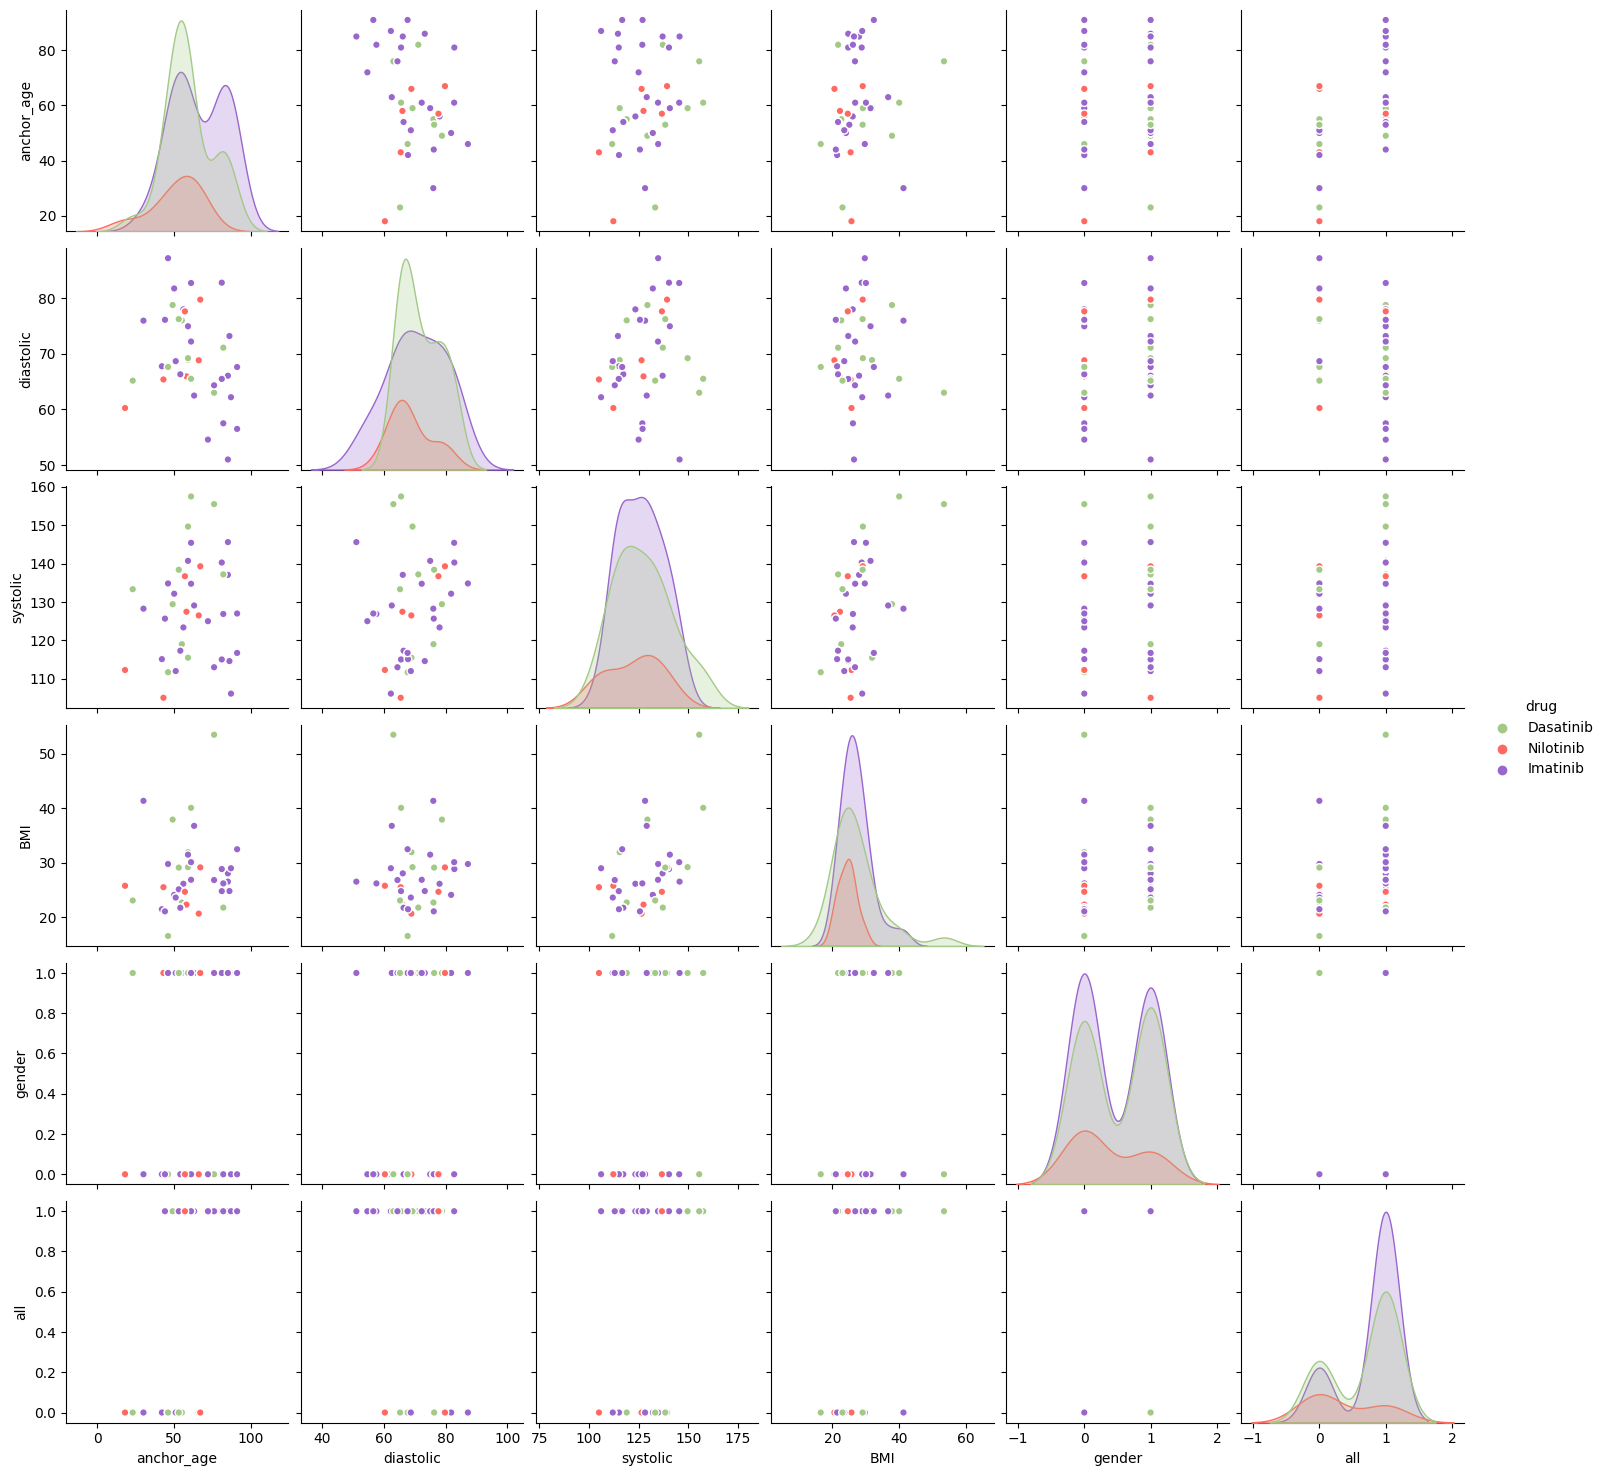

In [25]:
#  A scatterplot matrix of the data. Each plot shows a pair of risk factors, and the cases and controls are color coded (red is a case).

sns.pairplot(three_tki, 
             vars= ['anchor_age', 'diastolic', 'systolic', 'BMI', 'gender','all'], 
             kind="scatter", hue='drug',palette=['#a2c986', '#ff6961', '#9966cc'], #'#f7955d'
             plot_kws=dict(s=30, linewidth=1))#._legend.remove()

#'hypertensive','ischemic','pulmonary','other'

<AxesSubplot: >

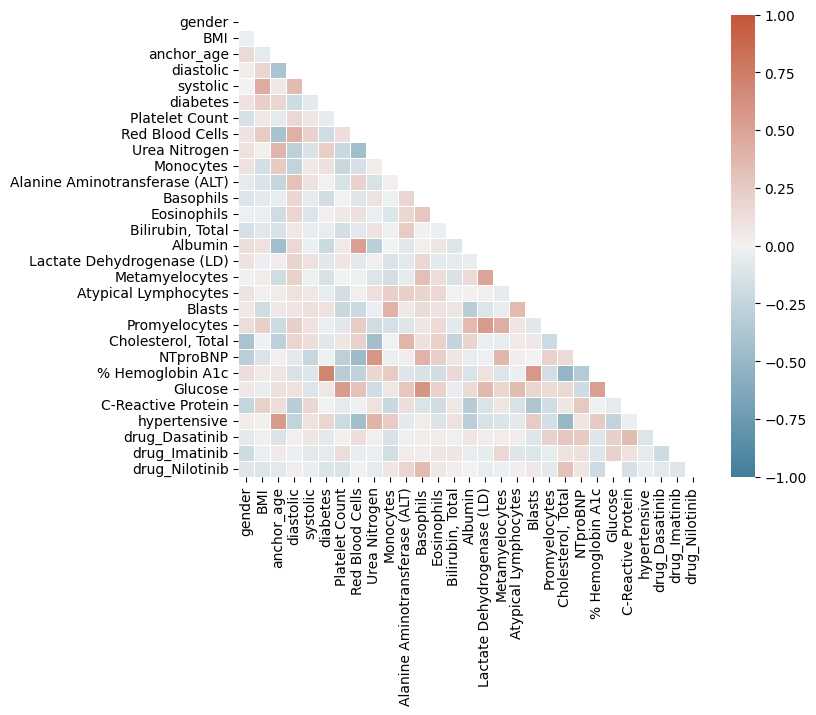

In [185]:
# Calculate correlation matrix 
# Check parameters: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html 
corr = feature_data.drop(['dose', 'drug_No_treatment'],axis=1).corr() # three_tki, method='pearson', 'kendall' , 'spearman'

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set_style()
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1,vmax=1, square=True, linewidths=.5)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer


def train_model(X, y):
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', None),
        ('classifier', None)
    ])

    # Define the scalers to be used
    scalers = {
        'Robust Scaler': RobustScaler(quantile_range=(10,90)),
        'Power Transformer': PowerTransformer(method='yeo-johnson')
    }

    # Define the classifiers to be used
    classifiers = {
        'LR': LogisticRegression(),
        'RF': RandomForestClassifier(n_estimators=1000),
#         "knn": KNeighborsClassifier(),
        "svm_linear": SVC(kernel="linear"),
        "xgb": xgb.XGBClassifier(n_estimators=1000),
#         "decision_tree": DecisionTreeClassifier(),
#         "svm_poly": SVC(kernel="poly"),
        "svm_rbf": SVC(kernel="rbf"),
#         "mlp": MLPClassifier(),
    }

    # Define the scoring metrics to be used (sklearn.metrics.get_scorer_names())
    scoring = {
        'Accuracy': 'accuracy',
        'Precision': 'precision',
        'Recall': 'recall',
        'AUC': 'roc_auc'
    }

    # Perform cross-validation for each scaler, classifier, and scoring metric
    results = {}
    for scaler_name, scaler in scalers.items():
        for classifier_name, classifier in classifiers.items():
            pipeline.set_params(scaler=scaler, classifier=classifier)
            cv_scores = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
            results[(scaler_name, classifier_name)] = cv_scores

    return results

In [51]:
from impyute.imputation.cs import mice

input_data_prediction = data_patient_all
### ['hypertensive','ischemic','pulmonary','other','cerebrovascular','arterioles','all']
full_CVD = ['hypertensive','ischemic','pulmonary','other','cerebrovascular','arterioles','all']
CVD_target = ["all"]

selected_lab = ['Red Blood Cells', 'Urea Nitrogen', 'Albumin', 'Lactate Dehydrogenase (LD)',
       'Metamyelocytes','Cholesterol, Total', '% Hemoglobin A1c', 'Glucose']

training_features = ['gender','BMI','anchor_age','diastolic','systolic','drug','dose', 'diabetes'] + CVD_target + selected_lab#lab_columns
feature_data = input_data_prediction.set_index('subject_id')[training_features]  # Your feature matrix
feature_data = pd.get_dummies(feature_data, columns=['drug']).drop(['drug_Ruxolitinib'],axis=1) #'drug_Cabozantinib','drug_Crizotinib'
feature_data['dose'] = feature_data['dose'].fillna(0)

feature_data['drug_Dasatinib'] = feature_data['drug_Dasatinib'] * feature_data['dose']
feature_data['drug_Imatinib'] = feature_data['drug_Imatinib'] * feature_data['dose']
feature_data['drug_Nilotinib'] = feature_data['drug_Nilotinib'] * feature_data['dose']
feature_data = feature_data.drop_duplicates()


In [174]:
syn_data = pd.read_csv("SynData/syn_data_file_withCVD_all.csv").drop('Unnamed: 0',axis=1)
syn_data

,gender,BMI,anchor_age,diastolic,systolic,diabetes,Platelet Count,Red Blood Cells,Urea Nitrogen,Monocytes,...,pulmonary,other,cerebrovascular,arterioles,all,drug_Cabozantinib,drug_Crizotinib,drug_Dasatinib,drug_Imatinib,drug_Nilotinib
0,1,25.321157,78,77.608205,109.517233,0,79.760427,4.538045,22.448106,6.951009,...,0,1,0,0,1,0,0,0.0,10.0,0.0
1,0,17.094096,68,76.240910,129.798498,0,234.156239,3.246122,7.000000,5.801466,...,0,0,0,0,1,0,0,0.0,0.0,2.9
2,0,23.183305,57,82.613437,129.064271,0,153.871592,3.173171,25.889839,13.313046,...,1,1,0,0,1,0,0,98.0,20.0,0.0
3,0,21.993909,50,62.207980,143.073912,1,21.250000,4.657064,48.571183,11.559783,...,0,1,0,0,1,0,0,45.0,10.0,0.2
4,0,17.305983,67,45.189766,109.003981,0,100.179879,2.628095,24.314478,13.173240,...,0,1,0,1,1,0,0,0.0,0.0,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,23.876632,47,90.627230,122.673743,0,86.109976,2.956517,19.079653,1.656559,...,1,1,0,0,1,0,0,1.0,0.0,0.0
996,0,23.935689,76,49.079970,137.040766,1,187.441537,2.913836,27.415359,7.876675,...,0,1,0,0,1,0,0,1.0,10.0,7.0
997,1,20.779645,43,61.922885,121.024318,0,137.765256,3.711741,7.000000,9.393744,...,0,1,0,0,1,0,0,2.0,20.0,0.0
998,1,26.404019,56,67.134540,153.701573,1,127.416008,4.852250,16.507612,26.577955,...,0,1,0,0,1,0,0,1.0,10.0,0.7


<AxesSubplot: ylabel='Density'>

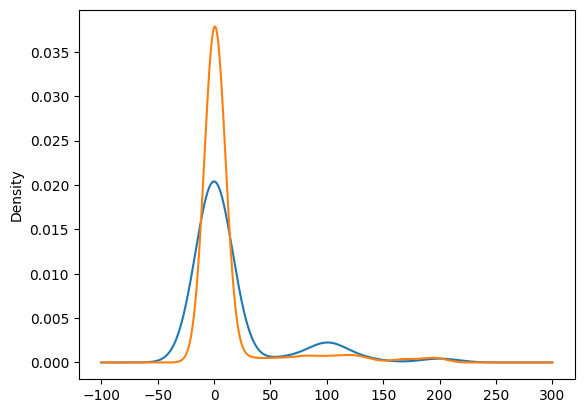

In [175]:
feature_data['drug_Dasatinib'].plot.kde()
syn_data['drug_Dasatinib'].plot.kde()

In [53]:
ML_input_data = feature_data#feature_data

target = ML_input_data[CVD_target] #data_patient_tki
try:
    ML_input_data = ML_input_data.drop(['drug_No_treatment','dose']+CVD_target, axis=1)
except:
    ML_input_data = ML_input_data.drop(full_CVD, axis=1)

imputed_data = mice(ML_input_data.values)
imputed_feature_data = pd.DataFrame(imputed_data,columns=ML_input_data.columns, index=ML_input_data.index)

X = imputed_feature_data
y = target  # Your target

# results = train_model(X, y)

# # Print cross-validation scores for each scaler, classifier, and scoring metric
# for (scaler_name, classifier_name), cv_scores in results.items():
#     print(f"Scaler: {scaler_name}, Classifier: {classifier_name}")
#     print("Cross-validation scores:")
#     for metric_name, metric_scores in cv_scores.items():
#         print(f"{metric_name}: {metric_scores.mean()} (Std: {metric_scores.std()})")
#     print()


In [157]:
import xgboost
# scaler = PowerTransformer(method='yeo-johnson')
# scaled_features = scaler.fit_transform(X)

scaled_features = X

# X_train, X_test, y_train, y_test = train_test_split(scaled_features, y[CVD_target[0]], test_size=0.2, random_state=7)

y_train = syn_data[CVD_target[0]]
y_test = feature_data[CVD_target[0]]
X_train = syn_data.drop(full_CVD+['drug_Crizotinib', 'drug_Cabozantinib'], axis=1)
X_test = feature_data.drop(['drug_No_treatment','dose']+CVD_target, axis=1)


d_train = xgboost.DMatrix(X_train, label=y_train, feature_names=X_train.columns) # X_train y_train
d_test = xgboost.DMatrix(X_test, label=y_test, feature_names=X_test.columns) # X_test y_test

In [158]:
params = {
    "eta": 0.0005,
    "objective": "binary:logistic",
    "subsample": 0.4,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=200, early_stopping_rounds=2000)

[0]	test-logloss:0.63880
[200]	test-logloss:0.63823
[400]	test-logloss:0.63838
[600]	test-logloss:0.63830
[800]	test-logloss:0.63825
[1000]	test-logloss:0.63887
[1200]	test-logloss:0.63929
[1400]	test-logloss:0.63962
[1600]	test-logloss:0.64041
[1800]	test-logloss:0.64167
[2000]	test-logloss:0.64256
[2197]	test-logloss:0.64308


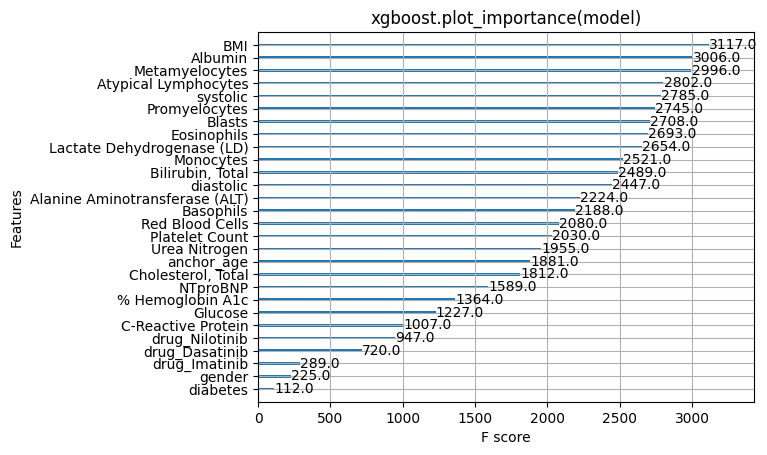

In [159]:
xgboost.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

<AxesSubplot: >

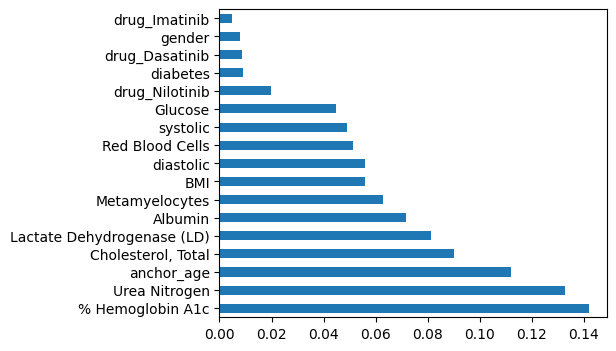

In [54]:

feature_data.column=X
rf = RandomForestClassifier()
rf.fit(X, y)
importance_scores = rf.feature_importances_
# feature_data.columns[importance_scores > 0.01]
# selected_features = feature_data[:, importance_scores > 0.01]  # Set an appropriate threshold

plt.figure(figsize = (5,4))
(pd.Series(rf.feature_importances_, index=X.columns).nlargest(30).plot(kind='barh')) 

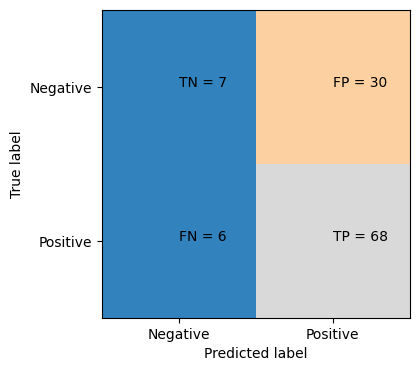

In [161]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=200, max_depth=30, learning_rate=0.01, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

def confusio_matrix(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,4))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.tab20c)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative','Positive'])
    plt.yticks(tick_marks, ['Negative','Positive'])
    s = [['TN','FP'], ['FN', 'TP']]
  
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

confusio_matrix(y_test,preds)

----

----